Лабораторная работа №5

Импорт библиотек

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from collections import Counter
import csv
import sys
import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from torch.utils.data import TensorDataset, DataLoader
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
sys.path.insert(1, "C:\\Users\\ksush\\OneDrive\\Рабочий стол\\python-v8\\Lab4")
from func import load_reviews

Считываем путь

In [124]:
data_folder = 'C:\\Users\\ksush\\OneDrive\\Рабочий стол\\python-v8\\dataset'
df = load_reviews(os.path.join(data_folder, 'normal_dataset.csv'))
print(df['Текст отзыва'])

0      \nДержат покупателей за лохов\nВ этом году (20...
1      \nОзон не доставил дорогостоящий ноутбук, хотя...
2      \n👎Я думала в WB беда с доставкой и сервисом. ...
3      \nСотрудничество с маркетплейсом или история о...
4      \nМошенники на Ozon и курьеры-воры\n14 июня я ...
                             ...                        
444                             Текст рецензии не найден
445                             Текст рецензии не найден
446                             Текст рецензии не найден
447                             Текст рецензии не найден
448                             Текст рецензии не найден
Name: Текст отзыва, Length: 449, dtype: object


In [125]:
change_labels = lambda x: 1 if x=="good" else 0
df['Class'] = df['Class'].apply(change_labels)
print(df['Class'])

0      0
1      0
2      0
3      0
4      0
      ..
444    0
445    0
446    0
447    0
448    0
Name: Class, Length: 449, dtype: int64


Удаление пустых строк

In [126]:
df.dropna(inplace=True)

Обработка текста отзыва

In [127]:
remove_non_alphabets = lambda x: re.sub(r'[^\w\s]', ' ', x, flags=re.UNICODE)

tokenize = lambda x: word_tokenize(x)

ps = PorterStemmer()
stem = lambda w: [ps.stem(x) for x in w]

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [lemmatizer.lemmatize(word) for word in x]

counter = lambda x: Counter(x)
sort_words = lambda x: list((dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:500])).keys())

In [128]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ksush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [129]:
print('Start processing')
df['Текст отзыва'] = df['Текст отзыва'].apply(remove_non_alphabets)
print('removed non alphabets')
df['Текст отзыва'] = df['Текст отзыва'].apply(tokenize)
print('tokenized')
df['Текст отзыва'] = df['Текст отзыва'].apply(stem)
print('stemmed')
df['Текст отзыва'] = df['Текст отзыва'].apply(leammtizer)
print('lemmatized')
df['Текст отзыва'] = df['Текст отзыва'].apply(counter)
print('counted')
df['Текст отзыва'] = df['Текст отзыва'].apply(sort_words)
print('sorted')
df['Текст отзыва'] = df['Текст отзыва'].apply(lambda x: ' '.join(x))
print('End of processing')

Start processing
removed non alphabets
tokenized
stemmed
lemmatized
counted
sorted
End of processing


Векторизация

In [144]:
russian_stopwords = stopwords.words('russian')
max_words = 500
cv = CountVectorizer(max_features=max_words, stop_words=russian_stopwords)
sparse_matrix = cv.fit_transform(df['Текст отзыва']).toarray()
sparse_matrix.shape

(449, 500)

Создание модели нейросети:

In [145]:
class Model(nn.Module):
   def __init__(self):
       super(Model, self).__init__()
       self.fc1 = nn.Linear(500, 50)
       self.fc2 = nn.Linear(50, 20)
       self.fc3 = nn.Linear(20, 10)
       self.fc4 = nn.Linear(10, 2)

   def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x

In [146]:
x_train, x_tmp, y_train, y_tmp = train_test_split(sparse_matrix, np.array(df['Class']), test_size=0.2, random_state=42)

Разделение на тестовую и валидационную выборку

In [147]:
x_test, x_valid, y_test, y_valid = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)
print(x_train.dtype)
print(y_train.dtype)

int64
int64


In [148]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

In [149]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [150]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 40
loss_values = []
models = []

Модель

In [151]:
model = Model()

Epoch 1/40, Training Loss: 0.7056, Training Accuracy: 0.0000, Validation Loss: 0.7038, Validation Accuracy: 0.0000
Epoch 2/40, Training Loss: 0.7021, Training Accuracy: 0.0000, Validation Loss: 0.7004, Validation Accuracy: 0.0000
Epoch 3/40, Training Loss: 0.6987, Training Accuracy: 0.0195, Validation Loss: 0.6971, Validation Accuracy: 0.0444
Epoch 4/40, Training Loss: 0.6950, Training Accuracy: 0.1226, Validation Loss: 0.6931, Validation Accuracy: 0.2222
Epoch 5/40, Training Loss: 0.6910, Training Accuracy: 0.8524, Validation Loss: 0.6891, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.6869, Training Accuracy: 1.0000, Validation Loss: 0.6849, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.6822, Training Accuracy: 1.0000, Validation Loss: 0.6800, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.6780, Training Accuracy: 1.0000, Validation Loss: 0.6755, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.6732, Training Accuracy: 1.0000, Validation Loss: 0

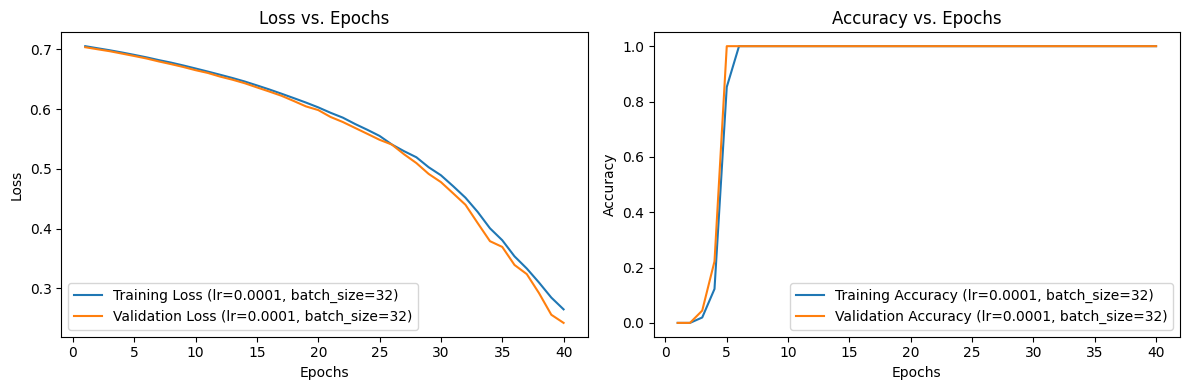

Epoch 1/40, Training Loss: 0.2497, Training Accuracy: 1.0000, Validation Loss: 0.2398, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.2440, Training Accuracy: 1.0000, Validation Loss: 0.2334, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.2362, Training Accuracy: 1.0000, Validation Loss: 0.2271, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.2290, Training Accuracy: 1.0000, Validation Loss: 0.2209, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.2247, Training Accuracy: 1.0000, Validation Loss: 0.2148, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.2171, Training Accuracy: 1.0000, Validation Loss: 0.2088, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.2114, Training Accuracy: 1.0000, Validation Loss: 0.2029, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.2059, Training Accuracy: 1.0000, Validation Loss: 0.1971, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.1999, Training Accuracy: 1.0000, Validation Loss: 0

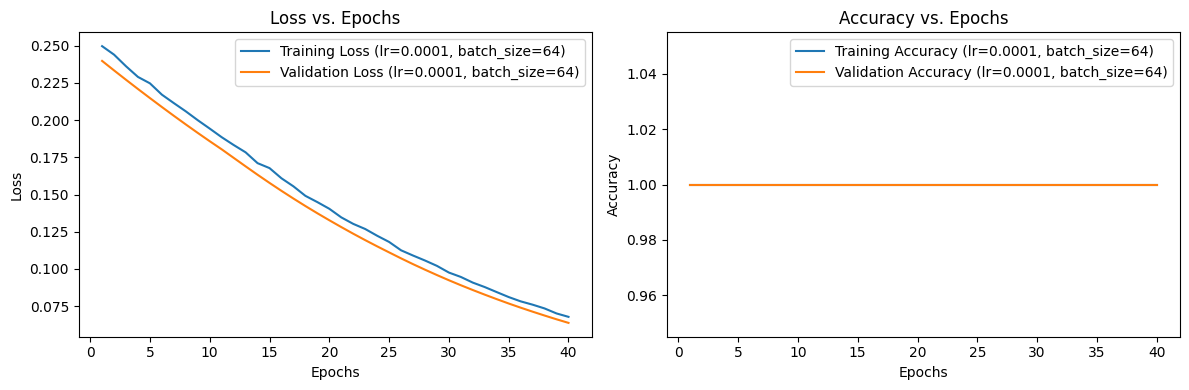

Epoch 1/40, Training Loss: 0.0656, Training Accuracy: 1.0000, Validation Loss: 0.0621, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0645, Training Accuracy: 1.0000, Validation Loss: 0.0605, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0628, Training Accuracy: 1.0000, Validation Loss: 0.0590, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0609, Training Accuracy: 1.0000, Validation Loss: 0.0574, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0595, Training Accuracy: 1.0000, Validation Loss: 0.0559, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0577, Training Accuracy: 1.0000, Validation Loss: 0.0544, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0563, Training Accuracy: 1.0000, Validation Loss: 0.0530, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0546, Training Accuracy: 1.0000, Validation Loss: 0.0516, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0535, Training Accuracy: 1.0000, Validation Loss: 0

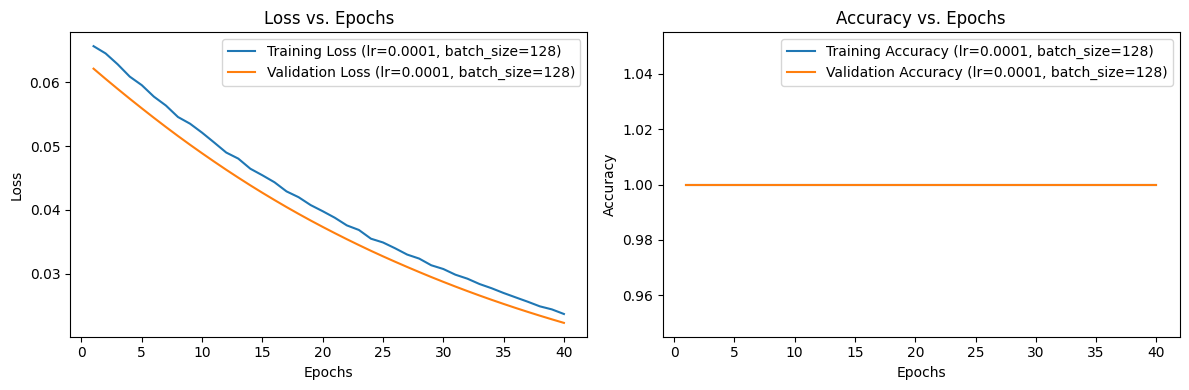

Epoch 1/40, Training Loss: 0.0130, Training Accuracy: 1.0000, Validation Loss: 0.0053, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0029, Training Accuracy: 1.0000, Validation Loss: 0.0012, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0009, Training Accuracy: 1.0000, Validation Loss: 0.0005, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 0.0003, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 0.0002, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 0.0002, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0

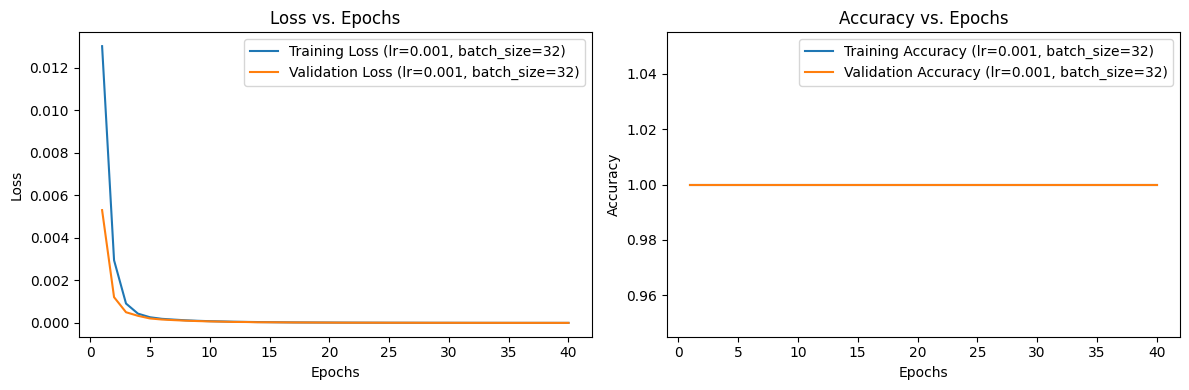

Epoch 1/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

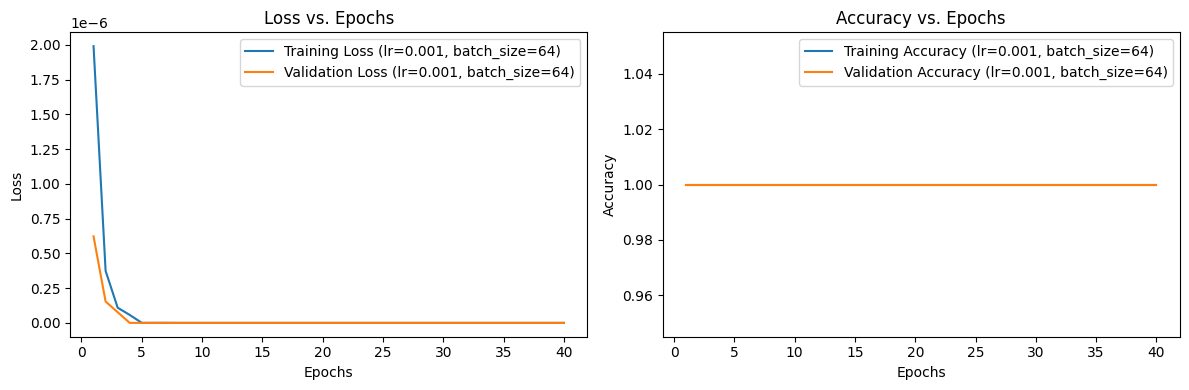

Epoch 1/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

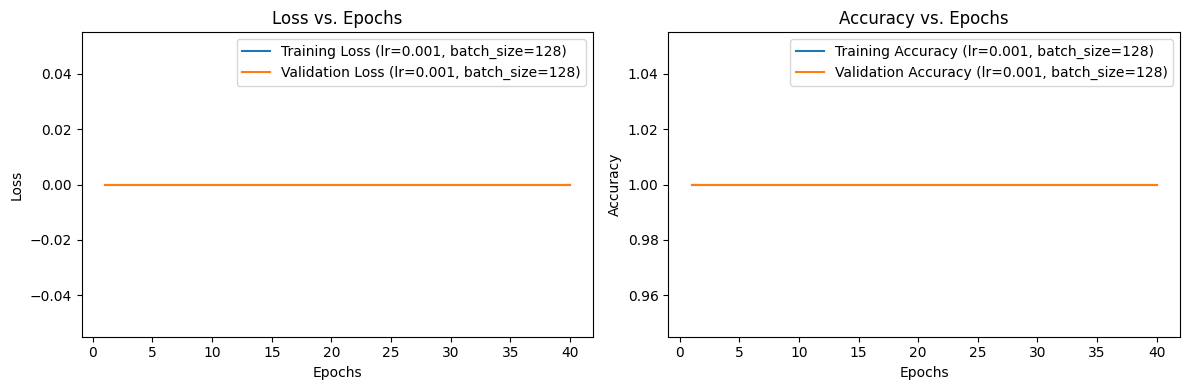

Epoch 1/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

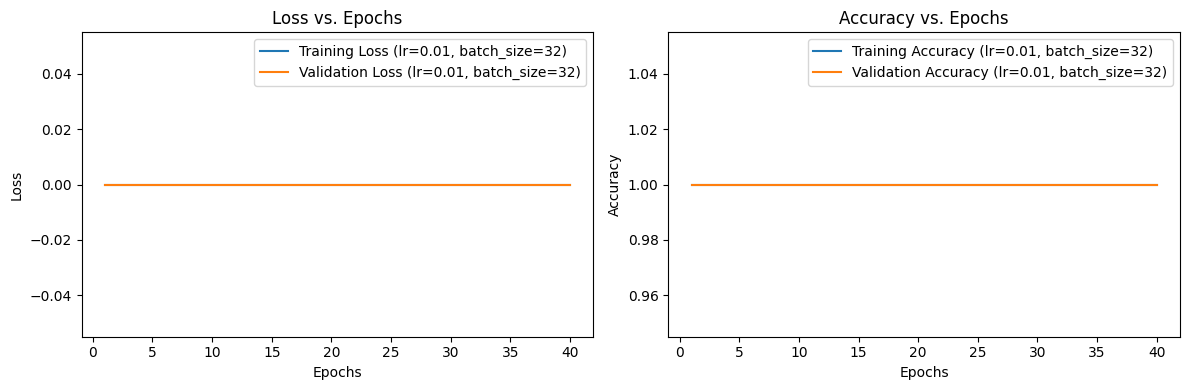

Epoch 1/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

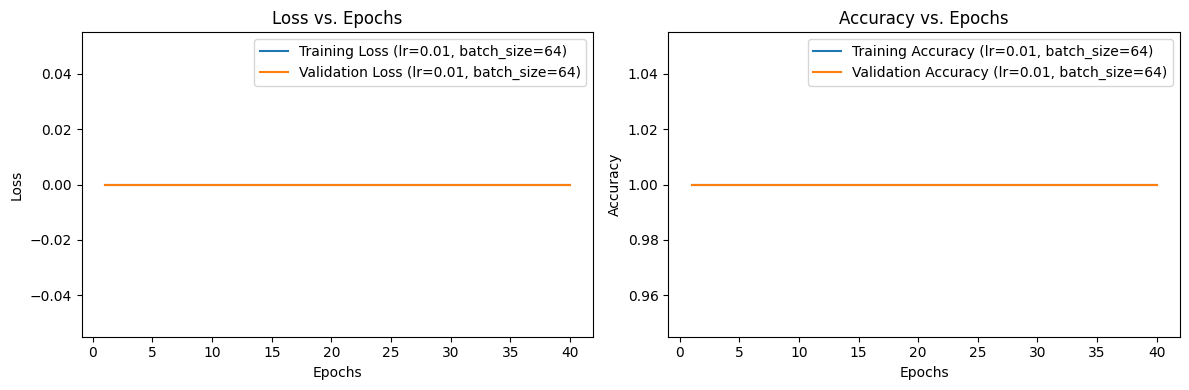

Epoch 1/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 2/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 3/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 4/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 6/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 9/40, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

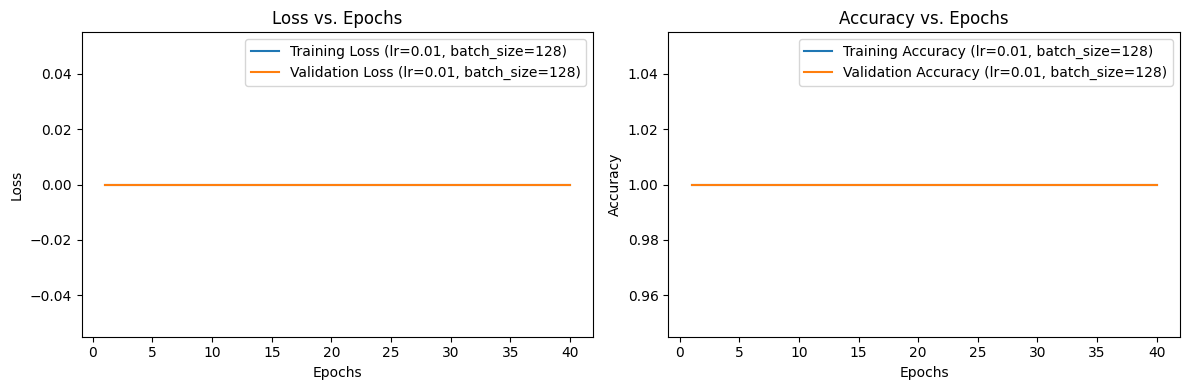

Test Accuracy: 1.0000


In [152]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

Повторная инициализация

In [115]:
batch_size = 32
lr = 0.0001
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 10

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

            # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)

Сохраняем модель

In [116]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

Тест

In [117]:
sample_review = """
Наглое и циничное издевательство над клиентами.
Что то видимо в Озоне окончательно сломалось. Такой наглости и циничного издевательства какое творит сейчас Озон со своими клиентами нужно еще поискать... Неделю назад заказала там альгинатную маску в большом обьеме.
"""

In [93]:
sample_review = remove_non_alphabets(sample_review)
sample_review = tokenize(sample_review)
sample_review = stem(sample_review)
sample_review = leammtizer(sample_review)
sample_review = counter(sample_review)
sample_review = sort_words(sample_review)
sample_review = ' '.join(sample_review)
sample_review

'и клиентами в наглое циничное издевательство над что то видимо озоне окончательно сломалось такой наглости циничного издевательства какое творит сейчас озон со своими нужно еще поискать неделю назад заказала там альгинатную маску большом обьеме'

In [94]:
max_words = 500
cv = CountVectorizer(max_features=max_words, stop_words=russian_stopwords)
sparse_matrix = cv.fit_transform(np.array([sample_review])).toarray()
if sparse_matrix.shape[1] < 500:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 500 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 500)

In [95]:
review = Variable(torch.from_numpy(sparse_matrix)).float()

In [96]:
model = Model()
loaded_checkpoint = torch.load('model.pth')
model.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch = loaded_checkpoint['epoch']

model.eval()

Model(
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)

In [97]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predicted_class = torch.argmax(output).item()

print(f"Предсказанный класс отзыва: {predicted_class}")

output:  tensor([[ 0.0325, -0.3258]])
Предсказанный класс отзыва: 0
